# DH Algorithm

Developed by Sanjoy **D**asgupta and Daniel **H**su, the DH algorithm operates on a hierarchical clustering. Iteratively, it works its way through the hierarchical tree and (in loose terms) estimates the error if the subsequent tree (pruning) were assigned the majority label to all the nodes. 

This implementation of DH is adapted from Haotian Teng's implementation, found at https://github.com/haotianteng/DH.

In [1]:
from dh import HierarchicalSampling as HS
import copy
import warnings
import numpy as np 
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from numpy.random import choice
from scipy.cluster.hierarchy import linkage
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import ClusterNode
warnings.filterwarnings("ignore")

In [2]:
def load_data(seed:int = 2021,
              filter_class:List[str] = None):
    """
    Loads "Protein Localizataion Prediction" data. Computes linkage from hierarchical clustering.

    Parameters
    ----------
    seed : int, optional
        A random seed. The default is 2021.
    filter_class : List[str], optional
        The labels of the samples to be used. The default is None.

    Returns
    -------
    X_train:  np.ndarray
        A N-by-M matrix where N is the number of sample and M is the number of
        features, used as training set.
    y_train : np.ndarray
        A length N vector, N is the number of samples. The label of the 
        training set.
    X_test : np.ndarray
        DESCRIPTION.
    y_test : np.ndarray
        DESCRIPTION.
    Z : np.ndarray
        A N-by-4 linkage matrix return by the scipy.cluster.hierarchy.linkage
        method for the training dataset, where N is the number sample - 1.
    class_n : int
        Number of classes.

    """

    df = pd.read_csv('/Users/jonathanzhu/Documents/data/vc_mutant_data.csv', header=None)
    df.columns = ['x' + str(i) for i in range(0, 512)] + ['Label']

    class_n = len(np.unique(df.Label))
    mask = df.Label ==0

    if not filter_class:
        filter_class = np.unique(df.Label)
    for x in filter_class:
        mask = mask | (df.Label==x)
        
    df = df[mask]
    X = df.iloc[:,:8].to_numpy()
    y = df.Label.astype('category').cat.codes.to_numpy()
    X, X_test, y, y_test = train_test_split(X,y,test_size = 0.2, random_state = seed)
    Z = linkage(X,method='ward')

    return X.astype("float"), y, X_test, y_test, Z , class_n

def compute_error(L:np.ndarray,labels:np.ndarray)->float:
    """
    Compute the error between the major label and the true label.

    Parameters
    ----------
    L : np.ndarray
        labeling of leaf nodes.
    labels : np.ndarray
        true labels of each node.

    Returns
    -------
    error : float
        error of predictions.

    """

    wrong = 0
    wrong = (L[:len(labels)]!=labels).sum()
    error = wrong/len(labels)
    return error

def prob_by_weight(nodes:List[int], count:List[int])->List[int]:
    """
    Get the probability of the given nodes list according to their weight.

    Parameters
    ----------
    nodes : List[int]
        The nodes list.
    count : List[int]
        Leaves count of the whole tree.

    Returns
    -------
    List[int]
        Leaves count of the given node list.

    """
    c = count[nodes]
    return c/c.sum()

def query_by_weight(prunning:List[int],leaves_count:List[int]):
    prob = prob_by_weight(prunning, leaves_count)
    return choice(prunning,p = prob)

def DH_sampling(x_train:np.ndarray,
                y_train:np.ndarray,
                linkage:np.ndarray,
                budget:int,
                batch_size:int,
                class_n:int,
                BETA:float = 2.0,
                sampling_method:str = "active"):
    """
    Conduct Hierchical sampling on the given dataset.

    Parameters
    ----------
    x_train : np.ndarray
        Training input.
    y_train : np.ndarray
        True label.
    linkage: np.ndarray
        The linkage matrix from scipy.cluster.hierarchy.linkage.
    budget : int
        Number of query.
    batch_size : int
        Query sample batch size.
    sampling_method : str, optional
        Sampling method, can be one of the following:"naive", "active". 
        The default is "active".

    Returns
    -------
    queries : List
        A list of actual query times.
    error : List
        A list of the label error rate.
    """
    hs = HS(linkage,x_train.shape[0], class_n)
    P = np.array([hs.btree.id]) #The prunning.
    error = []
    query_time = 0
    queries = []

    for i in np.arange(budget):
        for b in np.arange(batch_size):
            
            # Select a new node to expand by the weight.
            if sampling_method == "active":
                v = hs.active_sampling(P)
            elif sampling_method == "naive":
                v = query_by_weight(P,hs.leaves_count)
                
            # Pick a random leaf node from the subtree rooted at selected node.
            leaves = hs.get_leaves(v)
            leaf = np.random.choice(leaves)
            if not leaf.queryed:
                query_time+=1
            label = y_train[leaf.id]
            # update empirical counts and probabilityies for nodes on path
            # from the selected leaf to the selected subtree root.
            hs.update_empirical(leaf,v,label)
        hs.update_admissible(BETA)
        P = hs.best_pruning_and_labeling(P)
        for p in P:
            hs.assign_labels(p, p)
        error.append(compute_error(hs.major_label,y_train))
        queries.append(query_time) 
    return queries, error, hs,P

In [3]:
df = pd.read_csv('/Users/jonathanzhu/Documents/data/vc_mutant_data.csv', header=None)
#get list of classes in the final column
classes = df.iloc[:,-1].unique()
classes

array(['flaA', 'hapR', 'luxO_D47E', 'manA', 'potD1', 'rbmB', 'vpsL',
       'vpvC_W240R', 'WT'], dtype=object)

Begin DH naive sampling.
Currently on trial 0
Currently on trial 1
Currently on trial 2
Currently on trial 3
Currently on trial 4
Begin DH active sampling.
Currently on trial 0
Currently on trial 1
Currently on trial 2
Currently on trial 3
Currently on trial 4


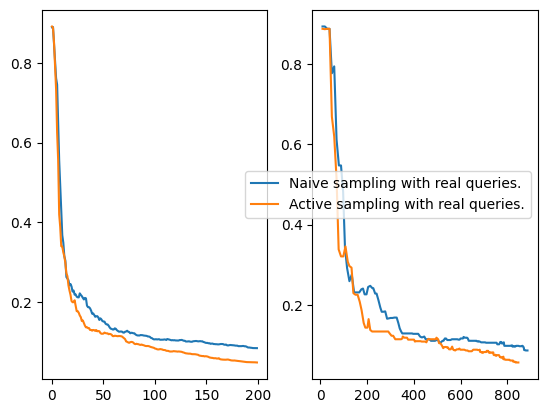

In [5]:
CLASSES = ['flaA', 'hapR', 'luxO_D47E', 'manA', 'potD1', 'rbmB', 'vpsL',
       'vpvC_W240R', 'WT']
X_train, y_train, X_test, y_test, Z ,_ = load_data(filter_class = CLASSES)

BUDGET = 200
BATCH_SIZE = 10
N = 5
figs,axs = plt.subplots(ncols = 2)

### naive sampling
l_naive = np.zeros(BUDGET)
print("Begin DH naive sampling.")

for i in np.arange(N):
    print("Currently on trial %d"%(i))
    queries,error,hs,P = DH_sampling(X_train, y_train, Z, BUDGET, BATCH_SIZE, class_n=9, sampling_method="naive")
    l_naive+=error

l_naive = l_naive/N
axs[0].plot(l_naive,label = "Naive sampling")
axs[1].plot(queries, error, label = "Naive sampling with real queries.")
    
## active sampling
l_active = np.zeros(BUDGET)
print("Begin DH active sampling.")
for i in np.arange(N):
    print("Currently on trial %d"%(i))
    queries,error,hs,P = DH_sampling(X_train, y_train, Z, BUDGET, BATCH_SIZE, class_n=9, sampling_method="active")
    l_active+=error
l_active = l_active/N
axs[0].plot(l_active,label = "Active sampling")
axs[1].plot(queries, error, label = "Active sampling with real queries.")
plt.legend()